###  수정사항
1. seed 2022 고정
2. model은 kobert-lm
3. train, valid, test 데이터셋에 문장들이 골고루 들어가게 설정
    > 사전에 미리 분리해 놓음
    > test : 라벨당 6개씩 추출(1122)
    > train, valid : 약 4:1 비율로 뽑음 (8959 1881)
4. early stop 적용

In [1]:
# 불러올 수많은 모듈들..
import json
from tokenization_kobert import KoBertTokenizer

import time
import datetime
import random

import pandas as pd
import numpy as np
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import accuracy_score

from transformers import AutoModelForSequenceClassification
from transformers import AutoConfig
from transformers import AdamW
from transformers import get_linear_schedule_with_warmup

import matplotlib.pyplot as plt
import seaborn as sns
import IPython

import torch
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

In [2]:
# 랜덤시드 설정
seed_val = 2022

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed(seed_val) # 멀티 gpu의 경우 뒤에 _all이 붙이면 됨

In [3]:
# 토크나이저 선언
tokenizer = KoBertTokenizer.from_pretrained("monologg/kobert-lm")

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'BertTokenizer'. 
The class this function is called from is 'KoBertTokenizer'.


In [4]:
# gpu 메모리 청소
torch.cuda.empty_cache()

# device = gpu 설정
if torch.cuda.is_available():     
    device = torch.device("cuda")
    print('%d개 존재함' % torch.cuda.device_count())
    print('사용할 GPU : ', torch.cuda.get_device_name(0))

# If not...
else:
    print('GPU 없어서 CPU로 설정')
    device = torch.device("cpu")

1개 존재함
사용할 GPU :  NVIDIA GeForce RTX 3060


In [7]:
## csv로 읽는 경우

trainn = pd.read_csv("data/final2_train2.csv",encoding="utf-8")
validd = pd.read_csv("data/final2_valid2.csv",encoding="utf-8")
testt = pd.read_csv("data/final2_test2.csv",encoding="utf-8")

# intent_list 생성
B = pd.read_csv("data/final2_title_node(187개).csv")
intent_list = list(B["title"])

In [8]:
trainn

,example,label
0,잘가,그만
1,bye,그만
2,상담 종료,그만
3,끝,그만
4,잘자요,그만
...,...,...
8954,이미 회원인데 어떻게 하지?,이미회원인경우
8955,이미 회원가입해서요,이미회원인경우
8956,벌써 가입했어요,이미회원인경우
8957,벌써 가입했거든요,이미회원인경우


In [9]:
# intent_dic 생성
intent_dic = {}
for i,x in enumerate(intent_list):
    intent_dic[x] = i

# intent 개수
print(len(intent_dic))

187


In [10]:
intent_dic

{'그만': 0,
 '실망및질책': 1,
 '일은잘하니': 2,
 '웃음': 3,
 '사과': 4,
 '감사': 5,
 '고객기분나쁨': 6,
 '고객기분좋음': 7,
 '수긍': 8,
 '노래': 9,
 '모바일쿠폰문의': 10,
 '회원정보변경': 11,
 '이름변경': 12,
 '정보메일수신거부': 13,
 '회원등급조건': 14,
 '회원최고등급': 15,
 '회원최하등급': 16,
 '회원가입혜택안내': 17,
 '회원탈퇴안내': 18,
 '회원ID분실': 19,
 '회원비밀번호분실': 20,
 '회원가입불가시': 21,
 '회원약관안내': 22,
 '탈퇴재가입가능여부': 23,
 '탈퇴재가입혜택이동': 24,
 '동원몰회원제': 25,
 '체험단이벤트안내': 26,
 '체험단배송안내': 27,
 '체험단배송비결제안내': 28,
 '체험단당첨안내': 29,
 '당첨경품배송': 30,
 '이달의이벤트안내': 31,
 '상품평혜택안내': 32,
 '현금영수증신청가능결제수단': 33,
 '현금영수증신청방법': 34,
 '현금영수증발급내역열람': 35,
 '현금영수증명의': 36,
 '발행종류': 37,
 '세금계산서요청방법': 38,
 '세금계산서금액기준': 39,
 '세금계산서공급자표시': 40,
 '세금계산서발행일자표시': 41,
 '세금계산서마감': 42,
 '세금계산서요청사업자등록증': 43,
 '제품색변화': 44,
 '제품보관법': 45,
 '레시피등록': 46,
 '고객만족센터연락처': 47,
 '고객만족센터운영시간': 48,
 '고객만족센터전화불통': 49,
 '문의내역확인': 50,
 '상품QA수정': 51,
 '직접문의안내': 52,
 '지금바로처리': 53,
 '클레임접수': 54,
 '해결불가건': 55,
 '임직원몰안내': 56,
 '임직원몰이동방법': 57,
 '임직원몰혜택': 58,
 '임직원포인트안내': 59,
 '임직원인증방법': 60,
 '회사위치': 61,
 '이달의기획전안내': 62,
 '타사문의': 63,
 '회사연락처

In [11]:
intent_list

['그만',
 '실망및질책',
 '일은잘하니',
 '웃음',
 '사과',
 '감사',
 '고객기분나쁨',
 '고객기분좋음',
 '수긍',
 '노래',
 '모바일쿠폰문의',
 '회원정보변경',
 '이름변경',
 '정보메일수신거부',
 '회원등급조건',
 '회원최고등급',
 '회원최하등급',
 '회원가입혜택안내',
 '회원탈퇴안내',
 '회원ID분실',
 '회원비밀번호분실',
 '회원가입불가시',
 '회원약관안내',
 '탈퇴재가입가능여부',
 '탈퇴재가입혜택이동',
 '동원몰회원제',
 '체험단이벤트안내',
 '체험단배송안내',
 '체험단배송비결제안내',
 '체험단당첨안내',
 '당첨경품배송',
 '이달의이벤트안내',
 '상품평혜택안내',
 '현금영수증신청가능결제수단',
 '현금영수증신청방법',
 '현금영수증발급내역열람',
 '현금영수증명의',
 '발행종류',
 '세금계산서요청방법',
 '세금계산서금액기준',
 '세금계산서공급자표시',
 '세금계산서발행일자표시',
 '세금계산서마감',
 '세금계산서요청사업자등록증',
 '제품색변화',
 '제품보관법',
 '레시피등록',
 '고객만족센터연락처',
 '고객만족센터운영시간',
 '고객만족센터전화불통',
 '문의내역확인',
 '상품QA수정',
 '직접문의안내',
 '지금바로처리',
 '클레임접수',
 '해결불가건',
 '임직원몰안내',
 '임직원몰이동방법',
 '임직원몰혜택',
 '임직원포인트안내',
 '임직원인증방법',
 '회사위치',
 '이달의기획전안내',
 '타사문의',
 '회사연락처',
 '동원홈페이지',
 '동원몰홈페이지',
 '동원소개',
 '대표이사안내',
 '동원몰소개',
 '동원몰앱안내',
 '입점문의',
 '동원몰상품문의',
 '동원몰매출',
 '전체카테고리안내',
 '동원입사',
 '임박상품',
 '천지인상품추천',
 '코스트코구매혜택',
 '동원브랜드및상품소개',
 '참치상품안내',
 '동원참치원산지',
 '만두상품안내',
 '리챔상품안내',
 '쎈쿡상품안내',
 '김치상품안내',
 '샘물상품안내',

In [13]:
# json_data을 읽어서 [["감사",굿],[]... ] 이런꼴로 만들자
# 그리고 "감사" -> dic에 맞게 수정

In [15]:
# 토큰화
train_content = []
valid_content = []
test_content = []


for x in trainn.iloc:
    if x["label"] in intent_list:
        train_content.append([tokenizer.tokenize(x["example"]),intent_dic[x["label"]]])

for x in validd.iloc:
    if x["label"] in intent_list:
        valid_content.append([tokenizer.tokenize(x["example"]),intent_dic[x["label"]]])

for x in testt.iloc:
    if x["label"] in intent_list:
        test_content.append([tokenizer.tokenize(x["example"]),intent_dic[x["label"]]])    

In [16]:
# 요소 하나 확인
print(train_content[2])
print(valid_content[2])
print(test_content[2])

[['▁상담', '▁종료'], 0]
[['▁상담', '▁종료', '해', '줘'], 0]
[['▁바', '이'], 0]


In [19]:
# 단어, 개체명 종류로 리스트 2개 분리
train_word = [x[0] for x in train_content]
train_num = [x[1] for x in train_content]

valid_word = [x[0] for x in valid_content]
valid_num = [x[1] for x in valid_content]

test_word = [x[0] for x in test_content]
test_num = [x[1] for x in test_content]

In [20]:
# 문장 길이 현황 확인 + max_len으로 고정
max_len = max(len(x) for x in token_word)

plt.hist([len(x) for x in token_word], bins=50)
plt.xlabel('length of sample')
plt.ylabel('number of sample')
plt.show()

print('최대 길이 : %d' % max_len)
print('최소 길이 : %d' % min(len(x) for x in token_word))
print('평균 길이 : %f' % (sum(map(len, token_word))/len(token_word)))

In [22]:
# input, attention 만들기
input_ids_train = []
attention_masks_train = []

input_ids_valid = []
attention_masks_valid = []

input_ids_test = []
attention_masks_test = []

for x in train_word:
    encoded_dict = tokenizer.encode_plus(
        x,
        add_special_tokens = True, # 이미 스페셜 토큰 넣긴했지만 일단 설정함
        max_length = max_len, # 최대길이
        truncation = True, # 넘어가면 잘라내기
        padding = "max_length", # 최대길이 이상은 패딩
        return_attention_mask = True, # 어텐션 마스크 설정
        return_tensors = "pt" # 파이토치 텐서로 출력
    )

    input_ids_train.append(encoded_dict["input_ids"]) # ids
    attention_masks_train.append(encoded_dict["attention_mask"]) # attention mask

for x in valid_word:
    encoded_dict = tokenizer.encode_plus(
        x,
        add_special_tokens = True, # 이미 스페셜 토큰 넣긴했지만 일단 설정함
        max_length = max_len, # 최대길이
        truncation = True, # 넘어가면 잘라내기
        padding = "max_length", # 최대길이 이상은 패딩
        return_attention_mask = True, # 어텐션 마스크 설정
        return_tensors = "pt" # 파이토치 텐서로 출력
    )

    input_ids_valid.append(encoded_dict["input_ids"]) # ids
    attention_masks_valid.append(encoded_dict["attention_mask"]) # attention mask

for x in test_word:
    encoded_dict = tokenizer.encode_plus(
        x,
        add_special_tokens = True, # 이미 스페셜 토큰 넣긴했지만 일단 설정함
        max_length = max_len, # 최대길이
        truncation = True, # 넘어가면 잘라내기
        padding = "max_length", # 최대길이 이상은 패딩
        return_attention_mask = True, # 어텐션 마스크 설정
        return_tensors = "pt" # 파이토치 텐서로 출력
    )

    input_ids_test.append(encoded_dict["input_ids"]) # ids
    attention_masks_test.append(encoded_dict["attention_mask"]) # attention mask

In [23]:
print("0번째 모양 :", input_ids_train[0])
print("크기 :", input_ids_train[0].size())
print("개수 :",len(input_ids_train))
print("==================")
print("0번째 모양 :", attention_masks_train[0])
print("크기 :",attention_masks_train[0].size())
print("개수 :",len(attention_masks_train))
print("==================")
print("0번째 모양 :", train_num[0])
print("개수 :",len(train_num))

0번째 모양 : tensor([[   2, 3942, 5330,    3,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1]])
크기 : torch.Size([1, 124])
개수 : 8959
0번째 모양 : tensor([[1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0,

In [26]:
print(len(input_ids_test),len(input_ids_train),len(input_ids_valid))
print(len(input_ids_test)+len(input_ids_train)+len(input_ids_valid))

1122 8959 1881
11962


In [27]:
# train, valid, test 별로 각 데이터가 제대로 있는 지 확인
print(len(input_ids_test),len(attention_masks_test),len(test_num))
print(len(input_ids_train),len(attention_masks_train),len(train_num))
print(len(input_ids_valid),len(attention_masks_valid),len(test_num))

1122 1122 1122
8959 8959 8959
1881 1881 1122


In [28]:
# 텐서들로 이루어져있는 리스트 -> 하나의 텐서로 만들기2
input_ids_train = torch.cat(input_ids_train, dim=0) #  dim = 0 으로 전환
attention_masks_train = torch.cat(attention_masks_train, dim=0) #  dim = 0 으로 전환
labels_train = torch.tensor(train_num) # 한줄 리스트라 이미 dim=0임

input_ids_valid = torch.cat(input_ids_valid, dim=0) #  dim = 0 으로 전환
attention_masks_valid = torch.cat(attention_masks_valid, dim=0) #  dim = 0 으로 전환
labels_valid = torch.tensor(valid_num) # 한줄 리스트라 이미 dim=0임

input_ids_test = torch.cat(input_ids_test, dim=0) #  dim = 0 으로 전환
attention_masks_test = torch.cat(attention_masks_test, dim=0) #  dim = 0 으로 전환
labels_test = torch.tensor(test_num) # 한줄 리스트라 이미 dim=0임

In [30]:
# tensordataset 모듈을 사용해서 합치기
train_dataset = TensorDataset(input_ids_train, attention_masks_train, labels_train)
val_dataset = TensorDataset(input_ids_valid, attention_masks_valid, labels_valid)
test_dataset = TensorDataset(input_ids_test, attention_masks_test, labels_test)

# 마지막으로 제대로 개수가 들어 있는지 확인
print(f"train_dataset : {len(train_dataset)}")
print(f"val_dataset : {len(val_dataset)}")
print(f"test_dataset : {len(test_dataset)}")
print(f"전체 dataset : {len(train_dataset)+len(val_dataset)+len(test_dataset)}")

train_dataset : 8959
val_dataset : 1881
test_dataset : 1122
전체 dataset : 11962


In [31]:
# 모델 만들기
model_name = "monologg/kobert-lm"

# 모델 설정 불러오기
config = AutoConfig.from_pretrained(model_name)

# 모델 라벨 개수 지정
config.num_labels = len(intent_dic)

# 모델에 attentions 존재함
config.output_attentions = True

In [32]:
# # 모델 설정 확인하려면
# print("config", config)

In [33]:
# 모델 불러오기(모델+설정)
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    config=config)

# 쿠다 사용할거야
model.cuda()

Some weights of the model checkpoint at monologg/kobert-lm were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at monologg/kobert-lm and are newly initialized: ['classifier

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(8002, 768, padding_idx=1)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementw

In [34]:
# 임의로 배치 사이즈 지정
batch_size = 32

# 데이터 로더 -> 배치사이즈에 맞게 잘 섞고 iter 형태로 전환
# valid, test는 굳이 섞을 필요가 없음(고정되있는게 오히려 비교하기 좋음)
# train
train_dataloader = DataLoader(
            train_dataset,
            sampler = RandomSampler(train_dataset),
            batch_size = batch_size
        )

# valid
validation_dataloader = DataLoader(
            val_dataset,
            sampler = SequentialSampler(val_dataset),
            batch_size = batch_size
        )

# test
test_dataloader = DataLoader(
            test_dataset,
            sampler = SequentialSampler(test_dataset),
            batch_size = batch_size
        )

In [35]:
# adamw 라는 새로운 옵티마이저 사용함
# https://hiddenbeginner.github.io/deeplearning/paperreview/2019/12/29/paper_review_AdamW.html
# 해보니깐 adam 도 마냥 만능이 아니라서 여러가지로 개선할 방법을 강구하는 과정에서 나온 것들

optimizer = torch.optim.AdamW(model.parameters(),
                  lr = 5e-5, # 학습률
                  eps = 1e-8 # 아담 엡실론
                )

c:\Users\YU\miniconda3\envs\py38\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [1]:
# train_Dataloader 개수 확인
# train_dataset / batch_size = 548.4... = 549 = len(train_dataloader) = train step 수 

print(len(train_dataset)/batch_size , len(train_dataloader))

NameError: name 'train_dataset' is not defined

In [39]:
# 반복 횟수 지정
epochs = 40

# 1 epoch당 train 기준 351번 step 밟음 -> 10epoch = 3510
total_steps = len(train_dataloader) * epochs

# 학습률 줄이는데에 시간이 오래걸리므로 처음 lr크기를 크게준후 epoch 마다 값을 감소시켜서 빠르게 도달하기
# 아니면 학습률 증가 -> 학습률 감소 식으로도 구현 가능
# cosine , linear, inverse_sqrt, constant ....

# 그중에서 우리는 1-cycle 스케줄링을 사용함 => linear하게 증가, 감소함.(옵티마이저는 그대로, )
scheduler = get_linear_schedule_with_warmup(optimizer,num_warmup_steps=0, num_training_steps=total_steps)

# 1-cycle 스케줄링의 경우
# num_warmup_steps : 이 step수에 해당할때까지 0부터 선형적으로 증가
# ex) 100 이면, 100에 이를때까지 0부터 linear하게 증가
# 100에 도달하고 그 이후부터는 linear하게 감소
# 그래서 일반적으로 train_dataloader 개수에 1/10 으로 지정하는 등으로 함
# # num_training_steps : 전체 step 수

## 저기서 num_warmup_steps 조정하면 여러번 적용 가능

In [40]:
# 실제값을이용하여 예측값의 정확도를 계산하는 함수 선언
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten() # 한줄로 나열
    labels_flat = labels.flatten() # 한줄로 나열2
    return np.sum(pred_flat == labels_flat) / len(labels_flat)
    # (틀리면0, 맞으면 1/전체 개수)의 총합 = ac 확률

In [41]:
# 데이터 분포가 불균형적이면, f1_score
# 데이터 분포가 균형적이면, acc

# 궁극적으로 구현해보고 싶은거
# warm_steps 조절해서 성능에 미치는 영향
# f1_score(micro)로 계산하게 동작
# test시 전체 분류표도 출력되게 동작

In [42]:
# 시간을 재봐요 함수

def format_time(elapsed):
    # 반올림해서 정수로 표현
    elapsed_rounded = int(round((elapsed)))
    
    # 시간/분/초로 출력되게 하자
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [44]:
# train,valid loss 와 valid acc 와 타임 로그도 저장할거야
training_stats = []

# 전체 걸린 시간 측정
total_t0 = time.time()

# valid loss가 학습할수록 줄어들면 동작  
patience = 3
first = 0 # 처음만 동작되게

# 에포크 마다 돌려돌려
for epoch_i in range(0, epochs):
    ## train ##
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Train!')

    # 1에포크당 걸린 시간 측정
    t0 = time.time()

    # 전체 손실 값 초기화
    total_train_loss = 0

    # train 모드로 전환한다는 뜻임(학습시작이 아님)
    model.train() 

    # batch 마다 돌려돌려
    for step, batch in enumerate(train_dataloader):

        # 50 스텝마다 
        if step % 50 == 0 and not step == 0:
            # 처음 시작에서 지나간 시간을 측정
            elapsed = format_time(time.time() - t0)
            
            # 과정 출력
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # 순서대로 ids, mask, labels이 담겨있음(batch 하나에)
        b_input_ids = batch[0].to(device) 
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # 미분 기울기는 항상 초기화해야해
        # 안그러면 학습할때마다 계속 기존의 미분 기울기에 적용되서 이상해져버려
        model.zero_grad()

        # 모델에 돌릴거야(순전파)
        M = model(input_ids=b_input_ids, attention_mask=b_input_mask, labels=b_labels)
        
        loss = M.loss
        logits = M.logits
        attentions = M.attentions

        # 나오는 loss값을 다 전체 손실값에 더할거야
        total_train_loss += loss.item()

        # 반대로 돌아가서 기울기를 역 계산하기(역전파)
        loss.backward()

        # 출력 길이에 따라 기울기 크기가 너무 커질수도 있으므로 해결하고자 하는 방법 중 하나
        # 쉬운 방법은 학습률을 작게 취하기(길이가 달라지므로 그에 맞는 학습률이 동적으로 변화 -> adam)'Adam
        # 그러나 일단 혹시 오버되는 일말의 문제에도 대처하기 위해서 작성함

        # 기울기 벡터 방향은 유지 + 크기만 적절하게 조절((1)보다 크면 동작함)
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # 역전파에서 계산한 기울기들을 각각 파라미터에 적용
        optimizer.step()

        # 학습률도 스케줄러에 설정한 옵션에 맞게 조정
        scheduler.step()

    # 1에포크마다 평균 train_loss를 구함(loss 총합/전체개수)
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # 1에포크까지 나온 시간 측정
    training_time = format_time(time.time() - t0)

    print("")
    print("  평균 training loss: {0:.2f}".format(avg_train_loss))
    print("  Training 1 epoch 걸린 시간: {:}".format(training_time))
    
    ## valid ##
    # 학습이 다 끝난후 valid 데이터 가지고 성능이 어느정도인지 확인

    print("")
    print("Valid!")

    t0 = time.time()

    # 평가 모드로 전환(+ dropout, batchnorm 비활성화해줌)
    # 메모리는 그대로
    model.eval()

    # torch.no_grad()을 사용하면 자동미분 계산기능을 아예 꺼버려서 메모리 줄이고 연산속도가 증가함
    # 대신 dropout 같은 요소들을 비활성화 하지 않음
    # 그래서 model.eval()로 드랍아웃 끄고, torch.no_grad()을 씌워서 메모리도 줄이는 형태로 되어있음

    # 변수들을 추적하자
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # 1에포크 시점
    for batch in validation_dataloader:
        
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # 순전파 돌린 값만을 보고 측정하기 떄문에 autograd 엔진 끔
        with torch.no_grad():   
            M = model(input_ids=b_input_ids, attention_mask=b_input_mask, labels=b_labels)
        
            loss = M.loss
            logits = M.logits
            attentions = M.attentions
            
        # valid loss 값 다 더해
        total_eval_loss += loss.item()

        # 결과 logits, 결과 라벨 -> cpu에 할당
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # 전체 acc 값에다 acc 계산 함수값을 계속 더해
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # 평균 acc 값을 구해서 출력
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # 1에포크에 걸처 나온 전체 loss 값을 평균화 하여 출력
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # valid 얼마나 걸렸는지 출력
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # 통계 수치들을 다 저장해놓자
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )
    # early stopping -> 자동으로 제일 나은 모델만 저장함
    if first == 0:
        before_valid = training_stats[-1]["Valid. Loss"]
        first = 1
    elif first == 1:
        if before_valid > training_stats[-1]["Valid. Loss"]:
            patience = 3
            before_valid = training_stats[-1]["Valid. Loss"]
            save_dir = "model/kobertLM_new_5" ## 자동으로 저장
            model.save_pretrained(save_dir)
            print("")
            print("save model's epochs : %d" % (epoch_i+1))
        elif before_valid <= training_stats[-1]["Valid. Loss"]:
            patience -= 1
            print("")
            print("Warning! patience : %d" % patience)
    
    if patience == 0:
        break

print("")
print("epochs Training complete!")

print("Total training 시간 {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 40 ========
Training...
  Batch    50  of    280.    Elapsed: 0:00:17.
  Batch   100  of    280.    Elapsed: 0:00:33.
  Batch   150  of    280.    Elapsed: 0:00:48.
  Batch   200  of    280.    Elapsed: 0:01:04.
  Batch   250  of    280.    Elapsed: 0:01:19.

  평균 training loss: 3.78
  Training 1 epoch 걸린 시간: 0:01:29

Running Validation...
  Accuracy: 0.66
  Validation Loss: 2.41
  Validation took: 0:00:06

======== Epoch 2 / 40 ========
Training...
  Batch    50  of    280.    Elapsed: 0:00:16.
  Batch   100  of    280.    Elapsed: 0:00:31.
  Batch   150  of    280.    Elapsed: 0:00:47.
  Batch   200  of    280.    Elapsed: 0:01:02.
  Batch   250  of    280.    Elapsed: 0:01:18.

  평균 training loss: 1.69
  Training 1 epoch 걸린 시간: 0:01:27

Running Validation...
  Accuracy: 0.85
  Validation Loss: 1.09
  Validation took: 0:00:06

save model's epochs : 2

======== Epoch 3 / 40 ========
Training...
  Batch    50  of    280.    Elapsed: 0:00:15.
  Batch   100  of    280

In [46]:
# pd로 데이터셋 만들기
df_stats = pd.DataFrame(data=training_stats)

# 칼럼 명칭 지정
df_stats = df_stats.set_index('epoch')

df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,3.780355,2.412683,0.656674,0:01:29,0:00:06
2,1.685537,1.089495,0.846038,0:01:27,0:00:06
3,0.749111,0.619466,0.903983,0:01:26,0:00:05
4,0.380501,0.416912,0.932055,0:01:20,0:00:05
5,0.213866,0.296982,0.946886,0:01:19,0:00:05
6,0.123768,0.240164,0.954831,0:01:19,0:00:05
7,0.074377,0.231157,0.953771,0:01:19,0:00:05
8,0.046147,0.198251,0.960657,0:01:19,0:00:05
9,0.029958,0.190963,0.962246,0:01:19,0:00:05


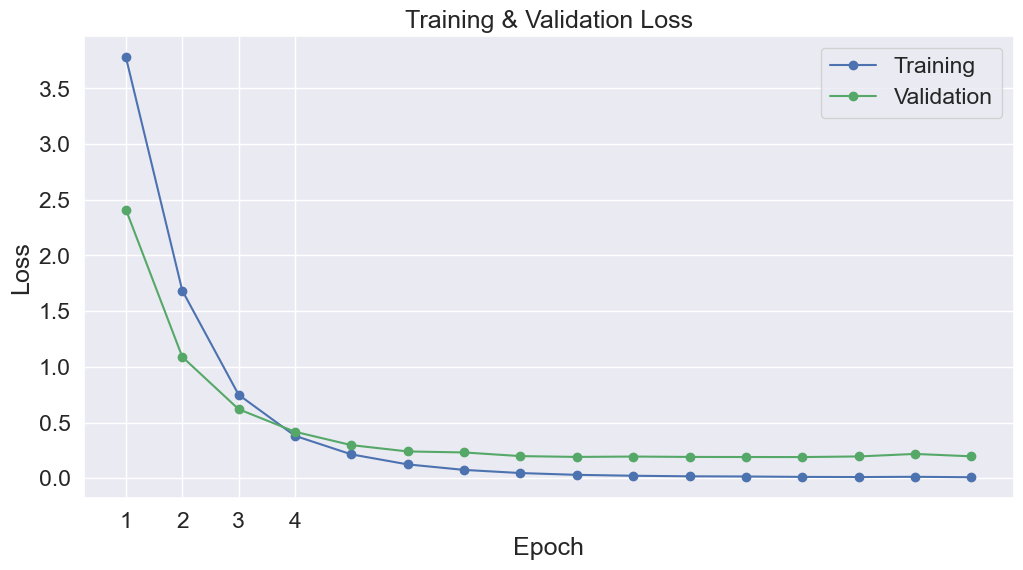

In [47]:
# seaborn 이용해서 그래프 출력
sns.set(style='darkgrid')

# 폰트 크기
sns.set(font_scale=1.5)

# 그림 크기
plt.rcParams["figure.figsize"] = (12,6)

# loss 출력
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# 축 이름 지정
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

In [49]:
# load해서 쓸거면
model2 = AutoModelForSequenceClassification.from_pretrained("model/kobertLM_new_5").cuda()

In [50]:
# 테스트 셋에 대하여 평가해봐요

print("Predict!")

# 평가 모드로 진입
model2.eval()

# 추적할 변수 선언
predictions , true_labels = [], []

# Predict 
for batch in test_dataloader:
  # batch에 있는 하나하나에 gpu 할당을 해줌 + batch 변수에 다시 저장
  batch = tuple(t.to(device) for t in batch)
  
  # batch 안에 들어있는 ids, mask, labels들을 다 끄집어 냄
  b_input_ids, b_input_mask, b_labels = batch

  # 순전파만 돌리는거니 autograd 끔
  with torch.no_grad():
      outputs = model(input_ids=b_input_ids,
                      attention_mask=b_input_mask)

  logits = outputs[0] # 0번째는 logits가 들어있음

  # logits, label -> cpu로 할당
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # 추적할 변수들안에 계속 차곡차곡 쌓기
  predictions.extend(logits)
  true_labels.extend(label_ids)

print(f"Predicted {len(predictions)} samples")

Predicting labels ...
Predicted 1122 samples


In [51]:
predictions = np.argmax(predictions, axis=1)
print(f"Test set accuracy: {accuracy_score(true_labels, predictions)}")

# f1_score은 사용하는 혼동 행렬들이 적기 때문에 모든 혼동행렬 종류들이 반영된 점수를 쓰는게 더 좋을 수 있다
# ㄴ 0,1을 구별하는 이진 분류에서의 이야기임
print(f"Test set Matthews correlation coefficient: {matthews_corrcoef(true_labels, predictions)}")

Test set accuracy: 0.9563279857397504
Test set Matthews correlation coefficient: 0.9561351885317081


In [52]:
### f1score을 재보자
from sklearn.metrics import f1_score, classification_report

In [53]:
print(f1_score(true_labels, predictions, average="micro")) # 동일하다

0.9563279857397504


In [54]:
label_list = list(intent_dic.values())

In [55]:
print(classification_report(true_labels, predictions, labels=list(label_list)))

              precision    recall  f1-score   support

           0       0.86      1.00      0.92         6
           1       1.00      1.00      1.00         6
           2       0.83      0.83      0.83         6
           3       1.00      1.00      1.00         6
           4       1.00      0.83      0.91         6
           5       0.86      1.00      0.92         6
           6       1.00      1.00      1.00         6
           7       1.00      0.83      0.91         6
           8       0.67      1.00      0.80         6
           9       1.00      1.00      1.00         6
          10       1.00      0.67      0.80         6
          11       1.00      1.00      1.00         6
          12       1.00      1.00      1.00         6
          13       1.00      1.00      1.00         6
          14       0.86      1.00      0.92         6
          15       1.00      1.00      1.00         6
          16       1.00      1.00      1.00         6
          17       1.00    

In [71]:
# # save
# save_dir = "model/kobertLM_new_3_epoch18"
# model.save_pretrained(save_dir)

In [105]:
# load해서 쓸거면
model2 = AutoModelForSequenceClassification.from_pretrained("model/kobertLM_new_3_epoch23").cuda()

In [73]:
# load 파라미터(변경시 꼭 수정해야해!)
max_len = 122

In [78]:
# prediction

# 예시 #
# 환불 때리고 싶은데 가능함?
# 휴대폰으로 결제하고 싶은데 어떻게 해야하나요?
# 비번 까먹었는데 어떻게 해야하나요?
# 대전 성심당에 빵 뭐 있는지 알고 싶어요
texts = [""]

In [80]:
# prediction

input_ids = []
attention_masks = []

for text in texts:
  encoded_dict = tokenizer.encode_plus(
                          text,            
                          add_special_tokens = True,
                          max_length = max_len,
                          pad_to_max_length = True, # padding =True 나 padding="longest" 같은걸로 대체하세요
                          return_attention_mask = True,
                          return_tensors = 'pt')
  
  input_ids.append(encoded_dict['input_ids'])

  attention_masks.append(encoded_dict['attention_mask'])

  input_ids = torch.cat(input_ids, dim=0)
  attention_masks = torch.cat(attention_masks, dim=0)

model2.eval()

predictions = []
last_layer_attentions = []

input_ids = input_ids.to(device)
attention_masks = attention_masks.to(device)

for i in range(len(input_ids)):

  ids = input_ids[i].unsqueeze(0)
  masks = attention_masks[i].unsqueeze(0)

  with torch.no_grad():
      outputs = model2(input_ids=ids,
                      attention_mask=masks)

  logits = outputs[0]
  logits = torch.softmax(logits,dim=1)
  last_layer_attention = outputs[1][-1]
  
  logits = logits.detach().cpu().numpy()
  last_layer_attention = last_layer_attention.detach().cpu().numpy()

  last_layer_attentions.append(last_layer_attention)
  predictions.append(logits)

In [81]:
probs = predictions[0][0]
print("text:", texts[0])
pred_idx = np.argmax(probs)
print(f"Prediction: {intent_list[pred_idx]} ({probs[pred_idx]:.2f})", )

text: 환불하고싶어
Prediction: 환불요청 (0.96)


In [22]:
# ### 전체 pred 값 ###
# print("predictions:", probs)

predictions: [4.86108800e-03 9.30860732e-03 5.83432615e-04 4.94632288e-04
 2.52864230e-03 4.51085670e-03 7.46212376e-04 1.50000374e-03
 4.25411621e-03 4.64140021e-06 1.21743241e-02 5.52538596e-03
 4.60196825e-05 2.44575064e-03 1.31486345e-03 9.87582374e-04
 1.35614304e-04 1.21928228e-03 7.30044363e-08 7.53255546e-01
 7.94948358e-03 1.61351042e-03 1.00046273e-04 9.36795899e-04
 5.14498039e-04 2.78299376e-06 4.90002676e-05 1.44488840e-05
 8.78564492e-07 1.52675057e-04 2.19308655e-04 7.23765173e-04
 9.17103971e-05 6.71113139e-06 3.99483688e-05 2.34663108e-04
 2.18029363e-05 8.02992872e-06 4.60721776e-06 1.28025877e-05
 4.44860859e-07 1.61666117e-04 1.75775762e-03 2.47934368e-05
 7.09049171e-04 1.59003917e-04 1.14525551e-06 3.93450428e-05
 1.78237009e-04 6.60132901e-06 1.85203215e-04 1.36930448e-05
 4.57918350e-06 9.16206161e-04 4.96171531e-04 6.95055423e-05
 3.34485012e-05 2.48830853e-04 2.83344858e-03 1.74507426e-04
 1.53111439e-04 3.69201007e-05 2.20334827e-04 3.17534577e-04
 5.81522007